# ARIMA model impelmentation


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model  import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace import tools 
import pandas as pd

In [2]:
def gen_series(ar, ma, length):
    ar_process = ArmaProcess(ar, ma)
    np.random.seed(99)

    X= ar_process.generate_sample(nsample=length)
    return X

In [3]:
ar_params = np.array([0.2, 0.15, 0.1]) 
ma_params = np.array([0.4, 0.2, 0.1]) 

ar = np.r_[1, -ar_params] # stacking 1 allows to include lag 0 in AR parameters  
ma = np.r_[1, ma_params] # Z_t is given by this term

X = gen_series(ar, ma, 1500)
# generate cumulative sum data which will be the data from ARIMA process 
# used to form a trend in the data
X = np.cumsum(X)

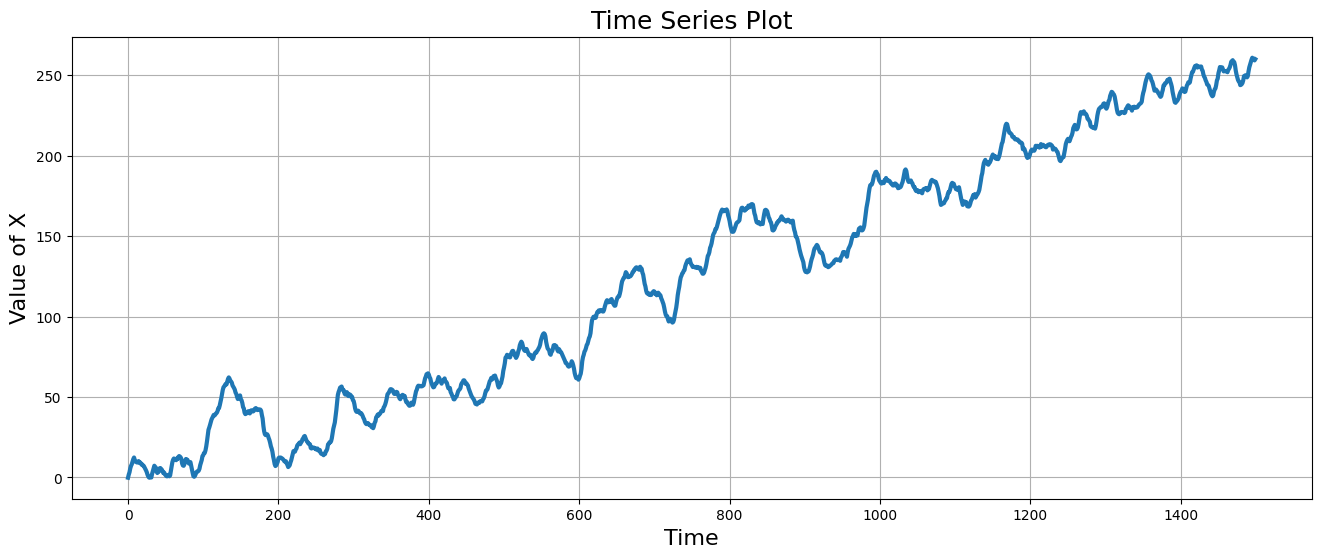

In [4]:
def plot_series(X, title='Time Series Plot', y_label='Value of X', figsize=(16, 6)):
    fig = plt.figure(figsize=figsize)
    plt.plot(X, linewidth=3)
    plt.title(title, fontsize=18)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel(y_label, fontsize=16)
    plt.grid()
    plt.show()

def plotCorr(x):
    plot_acf(x)
    plot_pacf(x)

plot_series(X)

This data is not stationary because we can see an upward going trend here. Such data with trends cannot be handled directly by the previous models like ARMA, AR, and MA. We will need to use differencing to remove such trends in the data first.

# Fiting the ARIMA(p,d,q) model

## Finding the order of d

We can create a loop such that it stops once the data is stationary. We'll use the Augmented Dicky-Fuller (ADF) test with a p-value threshold of  0.05
  to check the data's stationarity. 

In [5]:
p_threshold = 0.05

order_d = 0
X_diff = X.copy()

# loop to get stationary data 
while adfuller(X_diff)[1] > p_threshold:
    order_d += 1
    X_diff = tools.diff(X_diff)


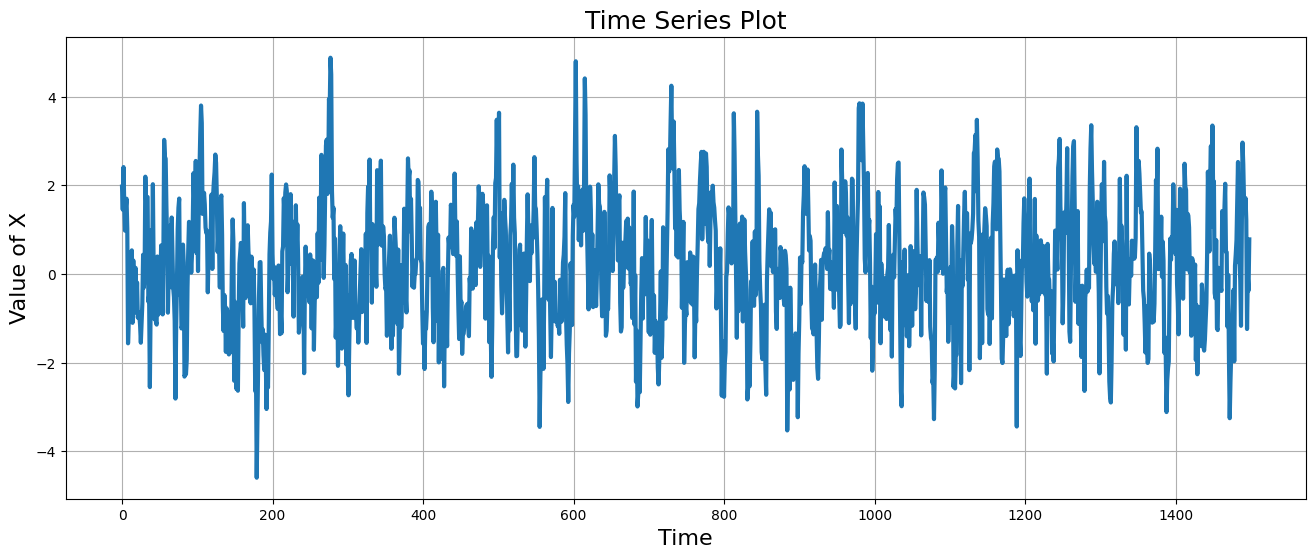

In [6]:
X_stationary = X_diff
d = order_d
plot_series(X_stationary)

## Finding order p and q

For this we will use the stationary series X and plot the ACF and PACF plot

c:\Users\dell\OneDrive\Documents\FuseMachine AI fellowship\Assignment Deep learning\assignment\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


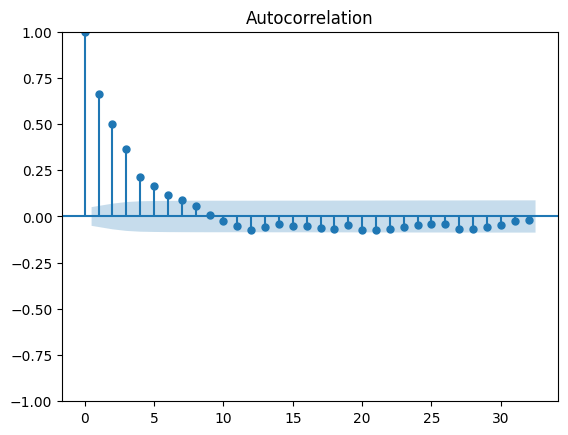

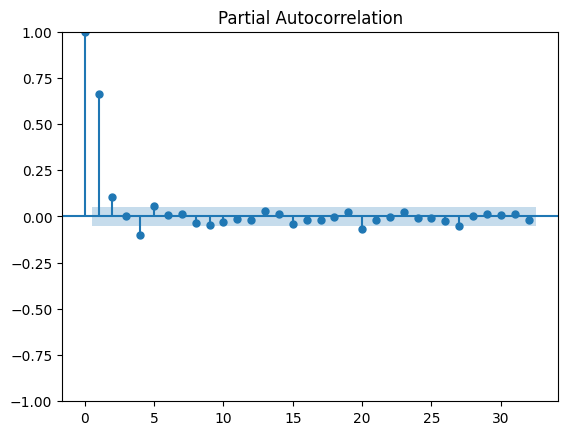

In [7]:
plotCorr(X_stationary)

Observing the ACF plot, the ACF values appear to cut off after lag 6. So we set  q to 6. Similarly, from the PACF plot, the PACF values appear to cut off after lag 5, so we set 𝑝 to 5.

In [8]:
p = 5
q =6

More precise method is to use pmdarima library that return the AIC score for various orders. Order with lowest AIC score is selected.

In [12]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')
fit = auto_arima(X, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4326.751, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5207.443, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4341.957, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4642.532, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5229.206, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4326.637, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4493.891, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4327.475, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4315.212, Time=0.34 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4348.000, Time=0.33 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4312.575, Time=0.73 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4314.190, Time=0.68 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=4313.596, Time=1.00 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=4311.709, Time=0.55 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept

# Fiting the model

In [13]:
# define model
model = ARIMA(X, order=(2,d, 5))
#fit the model
model_fit = model.fit()
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1500
Model:                 ARIMA(2, 1, 5)   Log Likelihood               -2149.623
Date:                Tue, 31 Oct 2023   AIC                           4315.245
Time:                        21:19:30   BIC                           4357.746
Sample:                             0   HQIC                          4331.079
                               - 1500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7683      0.080     22.180      0.000       1.612       1.925
ar.L2         -0.7946      0.069    -11.523      0.000      -0.930      -0.659
ma.L1         -1.1717      0.084    -13.893      0.0

Text(0, 0.5, 'Sales')

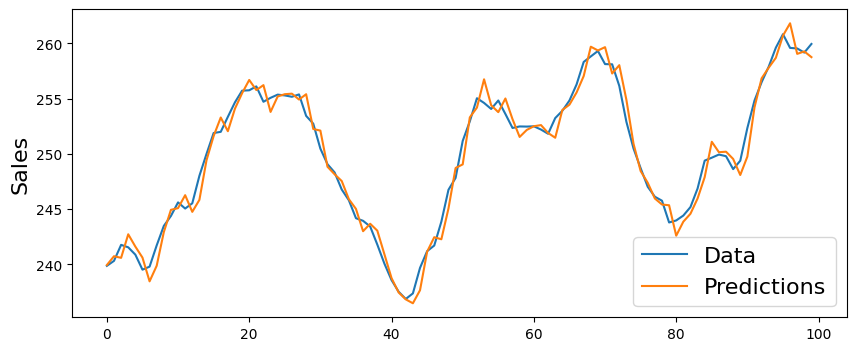

In [14]:
predictions = model_fit.predict(start = pd.Series(X).index[1400], end = pd.Series(X).index[-1])
plt.figure(figsize=(10,4))

plt.plot(X[1400:])
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.ylabel('Sales', fontsize=16)